In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

2.7.1+cu118
CUDA available: True
GPU: GeForce RTX 3050 Laptop GPU


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anilstha1","key":"39832804a83931ac6ebb4db197f18183"}'}

In [5]:
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.replace("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 600)


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)

d:\programming\deepfake_detection_in_images\AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 11.0M/3.75G [00:13<1:19:25, 842kB/s] 


KeyboardInterrupt: 

In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# import first dataset

df_train = pd.read_csv(f'{path}/train.csv',index_col=0)
df_val = pd.read_csv(f'{path}/valid.csv',index_col=0)
df_test = pd.read_csv(f'{path}/test.csv',index_col=0)

In [ ]:
df_train.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [ ]:
df_val.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


In [ ]:
df_test.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [ ]:
# remove not needed columns and shuffle
df_train = df_train.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_val = df_val.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_test = df_test.drop(columns=['original_path','id','label_str']).sample(frac=1)

In [ ]:
df_train.head()

,label,path
15136,0,train/fake/D1BPXHVMLY.jpg
43363,0,train/fake/30UFJZP11N.jpg
37741,1,train/real/54388.jpg
15339,0,train/fake/1A6BSUIXFS.jpg
21095,1,train/real/61529.jpg


In [ ]:
# rectify labels
df_train['label'] = 1 - df_train['label']
df_val['label'] = 1 - df_val['label']
df_test['label'] = 1 - df_test['label']

In [ ]:
# df_train=df_train[:5000]
# df_val=df_val[:1000]
# df_test=df_test[:1000]

In [ ]:
df_train.head()

,label,path
25966,0,/kaggle/input/140k-real-and-fake-faces/real_vs...
47422,1,/kaggle/input/140k-real-and-fake-faces/real_vs...
19909,1,/kaggle/input/140k-real-and-fake-faces/real_vs...
45788,1,/kaggle/input/140k-real-and-fake-faces/real_vs...
44259,0,/kaggle/input/140k-real-and-fake-faces/real_vs...


In [ ]:
# map each image name to its path
df_train["path"] = df_train["path"].map(lambda x: f'{path}/real_vs_fake/real-vs-fake/' + x)
df_val["path"]= df_val["path"].map(lambda x: f'{path}/real_vs_fake/real-vs-fake/' + x)
df_test["path"] = df_test["path"].map(lambda x: f'{path}/real_vs_fake/real-vs-fake/' + x)

In [ ]:
df_train.head()

,label,path
15136,1,/kaggle/input/140k-real-and-fake-faces/real_vs...
43363,1,/kaggle/input/140k-real-and-fake-faces/real_vs...
37741,0,/kaggle/input/140k-real-and-fake-faces/real_vs...
15339,1,/kaggle/input/140k-real-and-fake-faces/real_vs...
21095,0,/kaggle/input/140k-real-and-fake-faces/real_vs...


/tmp/ipython-input-4125964045.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img = Image.open(df_train["path"].iloc[int(random_idx)])
/tmp/ipython-input-4125964045.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = df_train['label'].iloc[int(random_idx)]


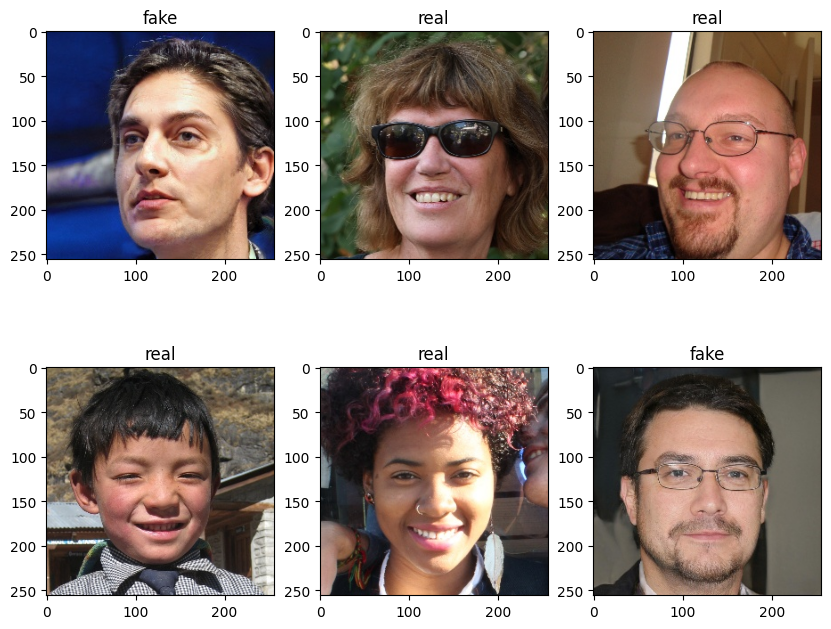

In [ ]:
# show a sample of images from the dataset with corresponding labels
label_arg = {0:'real', 1:'fake'}
fig, axs = plt.subplots(2,3,figsize=(10,8))
for i in range(2):
    for j in range(3):
        random_idx = np.random.randint(0,df_train.shape[0],1)
        img = Image.open(df_train["path"].iloc[int(random_idx)])
        label = df_train['label'].iloc[int(random_idx)]
        axs[i,j].imshow(img)
        axs[i,j].set_title(label_arg[label])

In [ ]:
class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row= self.df.iloc[idx]
        img_path = row["path"]
        image = Image.open(img_path).convert("RGB")
        label = row["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = DeepfakeDataset(df_train, transform=train_transform)
val_dataset   = DeepfakeDataset(df_val, transform=test_transform)
test_dataset  = DeepfakeDataset(df_test, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
for images, labels in train_loader:
    print(images.shape)  # [batch_size, 3, 224, 224]
    print(labels.shape)  # [batch_size]
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


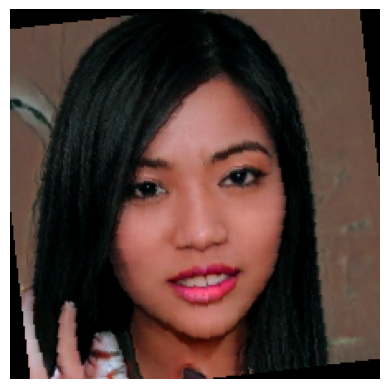

Label: 1


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Get one image and label from the dataset
image, label = train_dataset[0]  # index 0 for first image

# If image is a tensor, convert it to numpy and denormalize for plotting
def imshow(tensor_image):
    image_np = tensor_image.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

# Show image
imshow(image)
print("Label:", label)


In [ ]:
learning_rate=1e-3

In [ ]:
# EfficientNet Model

class EfficientNetBinary(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, dropout_rate=0.25):
        super(EfficientNetBinary, self).__init__()

        # Load pre-trained EfficientNetB0
        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)


        # Replace first conv layer if input channels != 3
        if input_channels != 3:
            self.base_model.features[0][0] = nn.Conv2d(
                input_channels, 32, kernel_size=3, stride=2, padding=1, bias=False
            )

        # freeze base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # unfreeze last 30 layers
        for layer in list(self.base_model.features[-1].children())[-30:]:
          for param in layer.parameters():
              param.requires_grad = True

        self.base_model.classifier = nn.Identity() # remove last layer

        num_features = self.base_model.features[-1][0].out_channels  # EfficientNetB0 last block output channels

        # Classification head using Sequential
        self.classifier = nn.Sequential(
            nn.Flatten(),                        # Flatten the output
            nn.Dropout(dropout_rate),            # Dropout
            nn.Linear(num_features, num_classes),# Linear layer
            nn.Sigmoid()                         # Sigmoid for binary classification
        )

    def forward(self, x):
        x = self.base_model(x)
        x=self.classifier(x)
        return x

In [ ]:
channels = 3
num_classes = 1

# model
model = EfficientNetBinary(input_channels=channels, num_classes=num_classes).to(device)
print(model)

EfficientNetBinary(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [ ]:
# loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): How many epochs to wait for improvement before stopping.
            min_delta (float): Minimum change to count as an improvement.
            verbose (bool): Print messages when improvement happens or stopping triggers.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        score= -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Save the best model when validation loss improves."""
        self.best_model = model.state_dict()
        if self.verbose:
            print("Validation loss decreased. Saving model...")


In [ ]:
# save checkpoint of model
def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

In [ ]:
# load checkpoint of model
def load_checkpoint(model, optimizer, path="checkpoint.pth", device='cpu'):
    """Load checkpoint to resume training"""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    return model, optimizer, start_epoch

In [ ]:
num_epochs=20;

In [1]:
import wandb

wandb.init(
    project="deepfake-detection",
    name="exp1",
    config={
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "loss_function": "BCELoss",
        "model": model.__class__.__name__,
    }
)

wandb.watch(model, log="all", log_freq=100)

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

early_stopping = EarlyStopping(patience=5, verbose=True)

checkpoint_path="/content/drive/MyDrive/deepfake_detection_images/checkpoint.pth"

start_epoch= 0

try:
  model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path, device)
except:
    print("No checkpoint found. Training from scratch.")

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap your training loader with tqdm
    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)

    for images, labels in train_pbar:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # BCELoss requires float

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar description dynamically
        train_pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{(correct / total):.4f}"
        })

        # wandb step logging
        wandb.log({
            "train_loss_step": loss.item(),
            "train_acc_step": correct/total,
        })

    train_loss = running_loss / total
    train_acc = correct / total

    # -------------------- Validation --------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Reset label + probability collector
    all_labels = []
    all_probs = []

    # tqdm for validation too
    val_pbar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)

    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_pbar.set_postfix({
                "Val Loss": f"{loss.item():.4f}",
                "Val Acc": f"{(val_correct / val_total):.4f}"
            })

            # -------- Collect labels + predicted probabilities --------
            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Print summary for the epoch
    print(f"\nEpoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # -------- Convert to numpy --------
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    pred_binary = (all_probs > 0.5).astype(int)

    # ------------------ Log confusion matrix ------------------
    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            y_true=all_labels,
            preds=pred_binary,
            title="Confusion Matrix"
        )
    })

    # ------------------ Log ROC curve + AUC ------------------
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    wandb.log({
        "roc_curve": wandb.plot.roc_curve(
            all_labels,
            all_probs,
            title="ROC Curve"
        ),
        "auc_score": roc_auc
    })

    # log full epoch metrics
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    # save checkpoint
    save_checkpoint(model, optimizer, epoch, checkpoint_path)

    # save checkpoint at wandb
    wandb.save(checkpoint_path)

    # ---------- Check Early Stopping ----------
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

Checkpoint loaded. Resuming from epoch 13



Epoch [14/20] Train Loss: 0.2067, Train Acc: 0.9155 Val Loss: 0.1354, Val Acc: 0.9490
Checkpoint saved at epoch 13
Validation loss decreased. Saving model...



Epoch [15/20] Train Loss: 0.2071, Train Acc: 0.9153 Val Loss: 0.1511, Val Acc: 0.9395
Checkpoint saved at epoch 14
EarlyStopping counter: 1/5



Epoch [16/20] Train Loss: 0.2008, Train Acc: 0.9178 Val Loss: 0.1383, Val Acc: 0.9447
Checkpoint saved at epoch 15
EarlyStopping counter: 2/5



Epoch [17/20] Train Loss: 0.1975, Train Acc: 0.9190 Val Loss: 0.1290, Val Acc: 0.9513
Checkpoint saved at epoch 16
Validation loss decreased. Saving model...



Epoch [18/20] Train Loss: 0.1967, Train Acc: 0.9202 Val Loss: 0.1357, Val Acc: 0.9473
Checkpoint saved at epoch 17
EarlyStopping counter: 1/5



Epoch [19/20] Train Loss: 0.1917, Train Acc: 0.9216 Val Loss: 0.1507, Val Acc: 0.9385
Checkpoint saved at epoch 18
EarlyStopping counter: 2/5



Epoch [20/20] Train Loss: 0.1927, Train Acc: 0.9222 Val Loss: 0.1351, Val Acc: 0.9469
Checkpoint saved at epoch 19
EarlyStopping counter: 3/5


In [ ]:
# Load the best saved model
model.load_state_dict(early_stopping.best_model)

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

model.eval()
test_correct = 0
test_total = 0

# Wrap test_loader with tqdm
test_pbar = tqdm(test_loader, desc="Testing", leave=False)

with torch.no_grad():
    for images, labels in test_pbar:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
torch.save(model, '/content/drive/MyDrive/deepfake_detection_images/models/model.pth')

In [ ]:
model=torch.load('/content/drive/MyDrive/deepfake_detection_images/models/model.pth',weights_only=False, map_location=torch.device('cpu'))
model.eval()

EfficientNetBinary(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [ ]:
# test image from test dataset
random_idx = np.random.randint(0, df_test.shape[0])
image_path = df_test["path"].iloc[random_idx]
label = df_test["label"].iloc[random_idx]
print("Image Path:", image_path)
print("Label:", label)

image= Image.open(image_path).convert("RGB")
image=transforms.Resize((224,224))(image)
image=transforms.ToTensor()(image)
image=image.unsqueeze(0)

pred= model(image);
pred_label= (pred>0.5).int().item()
print(f'prediction: {pred_label} , actual: {label}')

Image Path: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/52103.jpg
Label: 0
prediction: 0 , actual: 0


tensor([[0.7667]], grad_fn=<SigmoidBackward0>)